<h1> Import Libraries</h1>

In [1]:
import numpy as np 
import pandas as pd 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import glob as gb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
import PIL
import cv2
import random
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization
from keras.layers import Dropout
from tensorflow.keras.metrics import Precision, Recall
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers, Sequential, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2, VGG19, DenseNet121
from tensorflow.keras.models import Model

<h1> Loading The Data</h1>

In [2]:
BASE_DIR = '/kaggle/input/egyptian-hieroglyphs'
NEW_SIZE = 224

In [3]:
train_dir = os.path.join(BASE_DIR, 'train')
test_dir = os.path.join(BASE_DIR, 'test')
validation_dir = os.path.join(BASE_DIR, 'valid')

In [4]:
def print_directory_structure(directories):
    for directory in directories:
        for dirpath, dirnames, filenames in os.walk(directory):
            print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
print_directory_structure([train_dir, test_dir, validation_dir])

There are 0 directories and 2724 images in '/kaggle/input/egyptian-hieroglyphs/train'.
There are 0 directories and 390 images in '/kaggle/input/egyptian-hieroglyphs/test'.
There are 0 directories and 779 images in '/kaggle/input/egyptian-hieroglyphs/valid'.


In [6]:
def load_images_and_labels(directory, df):
    X = []
    y = []
    for i, img_name in enumerate(df['filename']):
        img_path = os.path.join(directory, img_name)
        img_class = df.loc[i, 'class']
        
        try:
            original_img = cv2.imread(img_path)
            image = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

            xmin, ymin, xmax, ymax = df.loc[i, ['xmin', 'ymin', 'xmax', 'ymax']]

            cropped_img = image[ymin:ymax, xmin:xmax]
            resized_img = cv2.resize(cropped_img, (NEW_SIZE, NEW_SIZE))
            X.append(resized_img)
            y.append(img_class)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
    return np.array(X), np.array(y)

In [7]:
df_train = pd.read_csv(gb.glob(train_dir + '/*.csv')[0])
X_train, y_train = load_images_and_labels(train_dir, df_train)

In [8]:
df_valid = pd.read_csv(gb.glob(validation_dir + '/*.csv')[0])
X_valid, y_valid = load_images_and_labels(validation_dir, df_valid)

In [9]:
df_test = pd.read_csv(gb.glob(test_dir + '/*.csv')[0])
X_test, y_test = load_images_and_labels(test_dir, df_test)

<h1>Visualisation</h1>

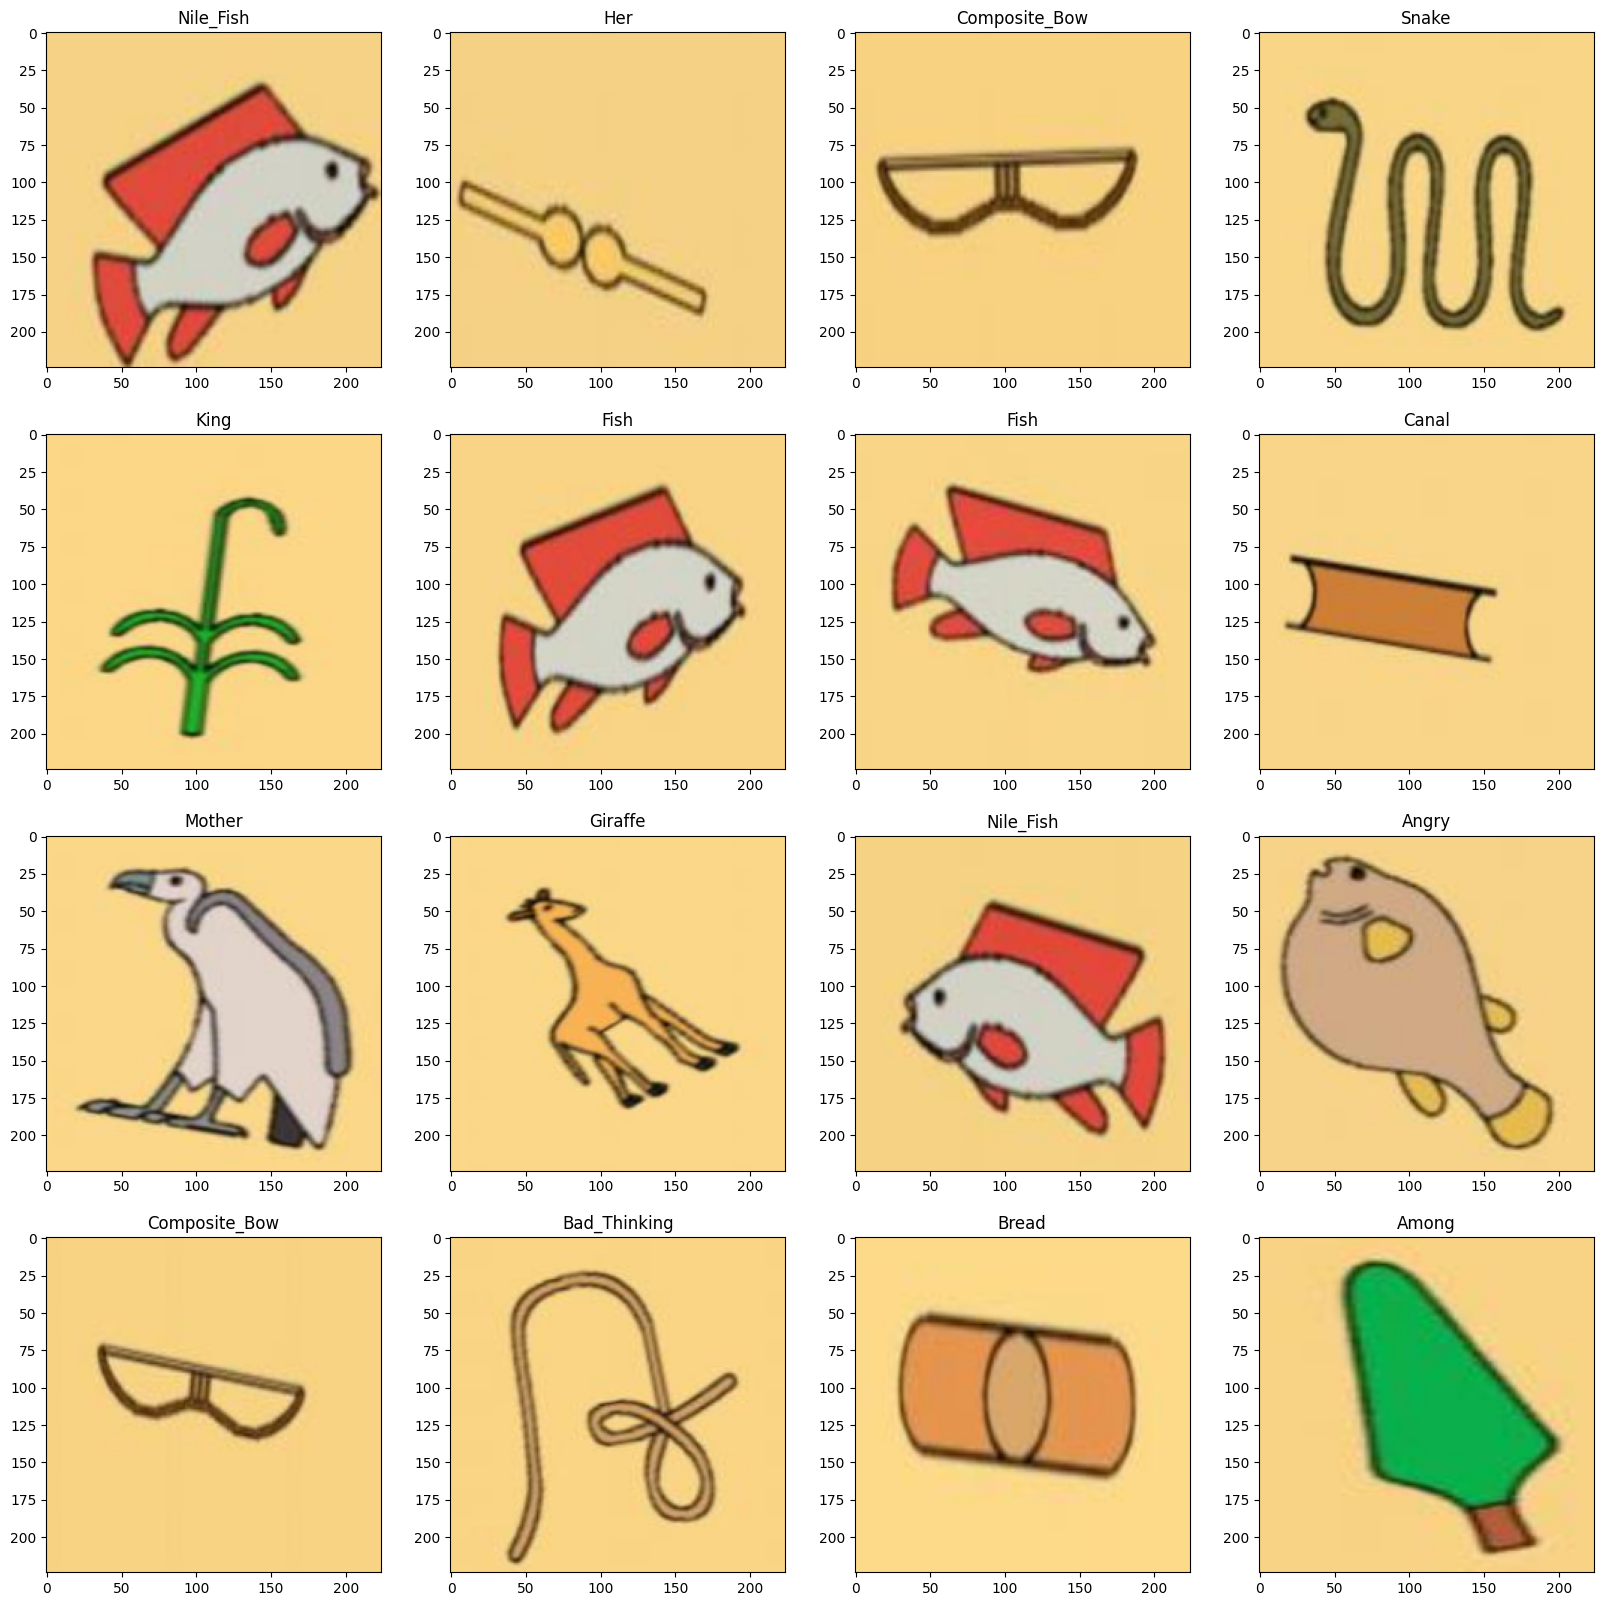

In [10]:
plt.figure(figsize=(20,20))

for i, n in enumerate(list(np.random.randint(0,len(X_train), 16))):
    plt.subplot(4, 4, i+1)
    plt.imshow(X_train[i])
    plt.title(y_train[i])

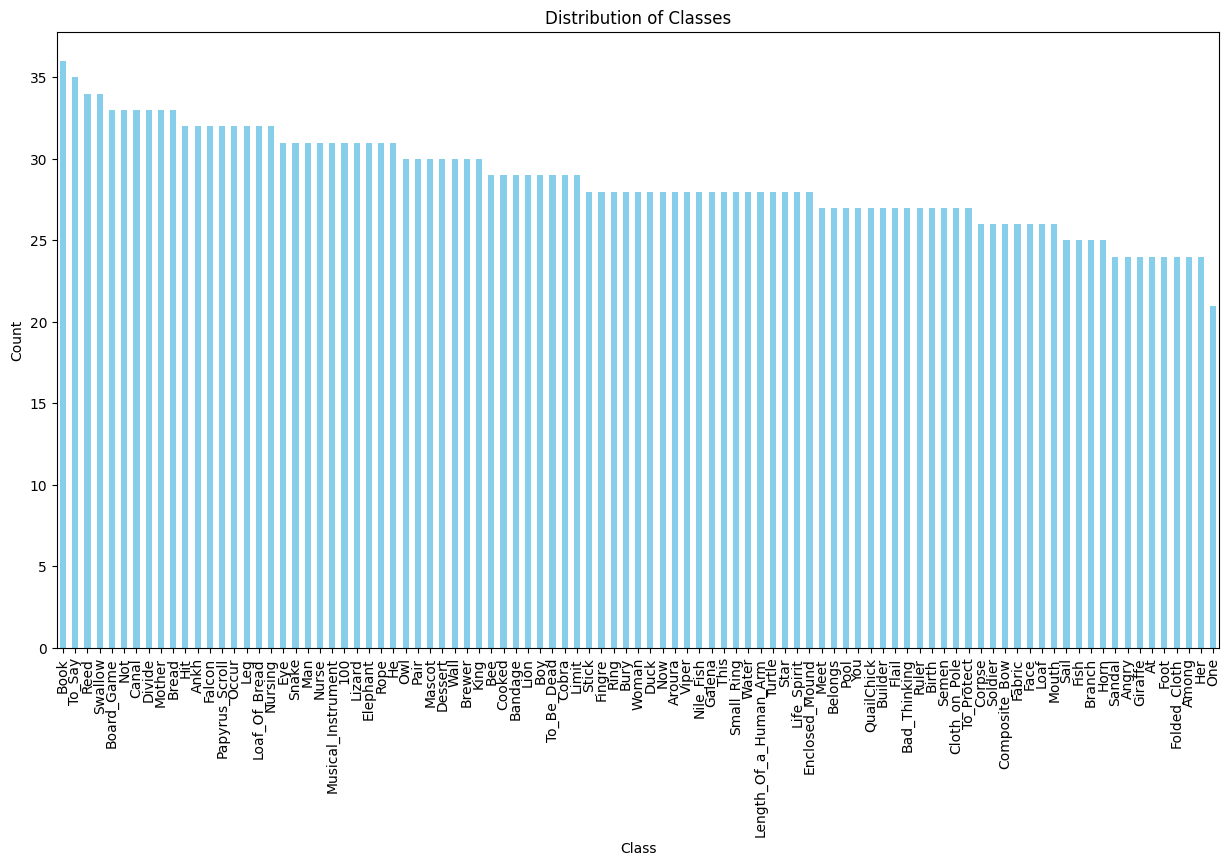

In [11]:
plt.figure(figsize=(15, 8))
df_train['class'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

<h1> Preprocessing</h1>

In [12]:
X_train = X_train.reshape(X_train.shape[0], NEW_SIZE, NEW_SIZE, 3)
X_valid = X_valid.reshape(X_valid.shape[0], NEW_SIZE, NEW_SIZE, 3)
X_test = X_test.reshape(X_test.shape[0], NEW_SIZE, NEW_SIZE, 3)

In [13]:
X_train, X_valid, X_test = X_train / 255.0, X_valid / 255.0, X_test / 255.0

In [14]:
X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [15]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

In [16]:
label_encoder = LabelEncoder()
y_train_encoded = to_categorical(label_encoder.fit_transform(y_train))
y_valid_encoded = to_categorical(label_encoder.transform(y_valid))
y_test_encoded = to_categorical(label_encoder.transform(y_test))

In [17]:
print('X_train shape: ', X_train.shape)
print('y_train_encoded shape: ', y_train_encoded.shape)
print('X_valid shape: ', X_valid.shape)
print('y_valid_encoded shape: ', y_valid_encoded.shape)
print('X_test shape: ', X_test.shape)
print('y_test_encoded shape: ', y_test_encoded.shape)

X_train shape:  (2723, 224, 224, 3)
y_train_encoded shape:  (2723, 95)
X_valid shape:  (778, 224, 224, 3)
y_valid_encoded shape:  (778, 95)
X_test shape:  (389, 224, 224, 3)
y_test_encoded shape:  (389, 95)


<h1>Modeling</h1>

In [18]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()


In [19]:
metrics = [
    'accuracy',
    Precision(),
    Recall(),
    F1Score()
]

<h2>Normal CNN</h2>

In [20]:
num_classes = len(df_train['class'].unique())  # Ensure you're using the training DataFrame
input_shape = (224, 224, 3)

# Build the model
model = Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     9,437,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 95)             │        24,415 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,850,271 (37.58 MB)

 Trainable params: 9,850,271 (37.58 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train) 
class_weight_dict = dict(enumerate(class_weights))

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

callbacks = [early_stopping]

In [24]:
history = model.fit(
    X_train, 
    y_train_encoded, 
    epochs=100, 
    validation_data=(X_valid, y_valid_encoded), 
    callbacks=callbacks
)

Epoch 1/100


I0000 00:00:1730087619.095268      70 service.cc:145] XLA service 0x7b84280090f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730087619.095354      70 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 5/86 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.0077 - f1_score: 0.0000e+00 - loss: 4.7603 - precision: 0.0000e+00 - recall: 0.0000e+00

I0000 00:00:1730087625.298853      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


86/86 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.0164 - f1_score: 0.0088 - loss: 4.5502 - precision: 0.4149 - recall: 0.0045 - val_accuracy: 0.1067 - val_f1_score: 0.0904 - val_loss: 4.0578 - val_precision: 0.9024 - val_recall: 0.0476
Epoch 2/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.1073 - f1_score: 0.0870 - loss: 4.0242 - precision: 0.5672 - recall: 0.0472 - val_accuracy: 0.2185 - val_f1_score: 0.2166 - val_loss: 3.2721 - val_precision: 0.7717 - val_recall: 0.1260
Epoch 3/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.2725 - f1_score: 0.2688 - loss: 2.9517 - precision: 0.6771 - recall: 0.1689 - val_accuracy: 0.6260 - val_f1_score: 0.5832 - val_loss: 1.4365 - val_precision: 0.8763 - val_recall: 0.4370
Epoch 4/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.5996 - f1_score: 0.5799 - loss: 1.4680 - precision: 0.8082 - recall: 0.4544 - val_accuracy: 0.8252 - val_f1_score: 0.7691 - val_loss: 0.6922 - val_precision: 0.9227 - val_recall: 0.6594
Ep

In [25]:
def evaluate_model(model, train_gen, valid_gen, test_gen):
    # Evaluate the model on the training data generator
    model_eval_train = model.evaluate(train_gen)
    print('Training Data:')
    print('Loss:      ', model_eval_train[0])
    print('Accuracy:  ', model_eval_train[1])
    print('Precision: ', model_eval_train[2])
    print('Recall:    ', model_eval_train[3])
    print('F1-Score:  ', model_eval_train[4])
    
    # Evaluate the model on the validation data generator
    model_eval_valid = model.evaluate(valid_gen)
    print('\nValidation Data:')
    print('Loss:      ', model_eval_valid[0])
    print('Accuracy:  ', model_eval_valid[1])
    print('Precision: ', model_eval_valid[2])
    print('Recall:    ', model_eval_valid[3])
    print('F1-Score:  ', model_eval_valid[4])
    
    # Evaluate the model on the test data generator
    model_eval_test = model.evaluate(test_gen)
    print('\nTest Data:')
    print('Loss:      ', model_eval_test[0])
    print('Accuracy:  ', model_eval_test[1])
    print('Precision: ', model_eval_test[2])
    print('Recall:    ', model_eval_test[3])
    print('F1-Score:  ', model_eval_test[4])
    
    return (np.round(model_eval_train[0], 2), np.round(model_eval_valid[0], 2), np.round(model_eval_test[0], 2),
            np.round(model_eval_train[1], 2), np.round(model_eval_valid[1], 2), np.round(model_eval_test[1], 2),
            np.round(model_eval_train[2], 2), np.round(model_eval_valid[2], 2), np.round(model_eval_test[2], 2),
            np.round(model_eval_train[3], 2), np.round(model_eval_valid[3], 2), np.round(model_eval_test[3], 2),
            np.round(model_eval_train[4], 2), np.round(model_eval_valid[4], 2), np.round(model_eval_test[4], 2))


In [26]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_encoded)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid_encoded)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test_encoded)).batch(32).prefetch(tf.data.AUTOTUNE)

evaluate_model(model, train_dataset, valid_dataset, test_dataset)


86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9974 - f1_score: 0.9974 - loss: 0.0116 - precision: 0.9974 - recall: 0.9974
Training Data:
Loss:       0.011514014564454556
Accuracy:   0.997062087059021
Precision:  0.997062087059021
Recall:     0.997062087059021
F1-Score:   0.9970620274543762
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9183 - f1_score: 0.9238 - loss: 0.2409 - precision: 0.9325 - recall: 0.9152

Validation Data:
Loss:       0.2655411660671234
Accuracy:   0.9280205368995667
Precision:  0.9409449100494385
Recall:     0.9215938448905945
F1-Score:   0.9311687350273132
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.9395 - f1_score: 0.9353 - loss: 0.2095 - precision: 0.9419 - recall: 0.9288

Test Data:
Loss:       0.19878950715065002
Accuracy:   0.9383033514022827
Precision:  0.9402597546577454
Recall:     0.9305912852287292
F1-Score:   0.9354004859924316


(0.01,
 0.27,
 0.2,
 1.0,
 0.93,
 0.94,
 1.0,
 0.94,
 0.94,
 1.0,
 0.92,
 0.93,
 1.0,
 0.93,
 0.94)

In [27]:
Final_report = []

In [28]:
Final_report.append(evaluate_model(model, train_dataset, valid_dataset, test_dataset))

86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9974 - f1_score: 0.9974 - loss: 0.0116 - precision: 0.9974 - recall: 0.9974
Training Data:
Loss:       0.011514014564454556
Accuracy:   0.997062087059021
Precision:  0.997062087059021
Recall:     0.997062087059021
F1-Score:   0.9970620274543762
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9183 - f1_score: 0.9238 - loss: 0.2409 - precision: 0.9325 - recall: 0.9152

Validation Data:
Loss:       0.2655411660671234
Accuracy:   0.9280205368995667
Precision:  0.9409449100494385
Recall:     0.9215938448905945
F1-Score:   0.9311687350273132
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9395 - f1_score: 0.9353 - loss: 0.2095 - precision: 0.9419 - recall: 0.9288

Test Data:
Loss:       0.19878950715065002
Accuracy:   0.9383033514022827
Precision:  0.9402597546577454
Recall:     0.9305912852287292
F1-Score:   0.9354004859924316


<h2>VGG19 Model</h2>

In [29]:
vgg19_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in vgg19_model.layers:
    layer.trainable = False

model = models.Sequential([
    vgg19_model,
    GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [30]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics= metrics)

# Fit the model on your training data
history = model.fit(X_train, y_train_encoded, epochs=100, validation_data=(X_valid, y_valid_encoded), callbacks=callbacks)

Epoch 1/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 30s 206ms/step - accuracy: 0.2232 - f1_score: 0.4383 - loss: 3.6463 - precision: 0.9346 - recall: 0.3011 - val_accuracy: 0.1812 - val_f1_score: 0.0000e+00 - val_loss: 3.7994 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - accuracy: 0.8873 - f1_score: 0.6523 - loss: 0.9107 - precision: 0.9639 - recall: 0.4961 - val_accuracy: 0.8663 - val_f1_score: 0.0000e+00 - val_loss: 2.9805 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - accuracy: 0.9569 - f1_score: 0.9019 - loss: 0.3679 - precision: 0.9774 - recall: 0.8375 - val_accuracy: 0.9627 - val_f1_score: 0.0026 - val_loss: 1.9899 - val_precision: 1.0000 - val_recall: 0.0013
Epoch 4/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - accuracy: 0.9663 - f1_score: 0.9503 - loss: 0.2208 - precision: 0.9729 - recall: 0.9287 - val_accuracy: 0.9473 - val_f1_score: 0.4740 - val_loss: 0.9680 - val_pr

In [31]:
Final_report.append(evaluate_model(model, train_dataset, valid_dataset, test_dataset))

86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.9825 - f1_score: 0.9821 - loss: 0.0319 - precision: 0.9825 - recall: 0.9818
Training Data:
Loss:       0.028543636202812195
Accuracy:   0.9864120483398438
Precision:  0.9864020347595215
Recall:     0.9856775403022766
F1-Score:   0.9860395789146423
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.9689 - f1_score: 0.9689 - loss: 0.0707 - precision: 0.9689 - recall: 0.9689

Validation Data:
Loss:       0.06733623892068863
Accuracy:   0.9717223644256592
Precision:  0.9717223644256592
Recall:     0.9717223644256592
F1-Score:   0.9717223048210144
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 260ms/step - accuracy: 0.9759 - f1_score: 0.9759 - loss: 0.0667 - precision: 0.9759 - recall: 0.9759

Test Data:
Loss:       0.061043672263622284
Accuracy:   0.9768637418746948
Precision:  0.9768637418746948
Recall:     0.9768637418746948
F1-Score:   0.97686368227005


<h2>MobileNetV2 Model</h2>

In [32]:
mobilenetv2_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in mobilenetv2_model.layers:
    layer.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [33]:
model = models.Sequential([
    mobilenetv2_model,
    GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

In [34]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=metrics)

In [35]:
history = model.fit(
    X_train, 
    y_train_encoded, 
    epochs=100, 
    validation_data=(X_valid, y_valid_encoded), 
    callbacks=callbacks
)

Epoch 1/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 25s 159ms/step - accuracy: 0.4475 - f1_score: 0.6421 - loss: 2.7749 - precision: 0.9476 - recall: 0.4909 - val_accuracy: 0.9627 - val_f1_score: 0.9088 - val_loss: 0.3762 - val_precision: 0.9736 - val_recall: 0.8522
Epoch 2/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9675 - f1_score: 0.9502 - loss: 0.2120 - precision: 0.9759 - recall: 0.9259 - val_accuracy: 0.9627 - val_f1_score: 0.9593 - val_loss: 0.1858 - val_precision: 0.9649 - val_recall: 0.9537
Epoch 3/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9711 - f1_score: 0.9721 - loss: 0.1118 - precision: 0.9751 - recall: 0.9692 - val_accuracy: 0.9692 - val_f1_score: 0.9678 - val_loss: 0.0813 - val_precision: 0.9691 - val_recall: 0.9666
Epoch 4/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9760 - f1_score: 0.9747 - loss: 0.0932 - precision: 0.9776 - recall: 0.9718 - val_accuracy: 0.9717 - val_f1_score: 0.9704 - val_loss: 0.0869 - val_precision: 0.9716 - val_recal

In [36]:
Final_report.append(evaluate_model(model, train_dataset, valid_dataset, test_dataset))

86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.9692 - f1_score: 0.9411 - loss: 0.3074 - precision: 0.9882 - recall: 0.8984
Training Data:
Loss:       0.30147477984428406
Accuracy:   0.9728240966796875
Precision:  0.9863508343696594
Recall:     0.9023136496543884
F1-Score:   0.9424625635147095
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.9699 - f1_score: 0.9127 - loss: 0.3726 - precision: 0.9803 - recall: 0.8539

Validation Data:
Loss:       0.3761843740940094
Accuracy:   0.9627249240875244
Precision:  0.9735682606697083
Recall:     0.852185070514679
F1-Score:   0.908841609954834
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step - accuracy: 0.9699 - f1_score: 0.9104 - loss: 0.3457 - precision: 0.9855 - recall: 0.8466

Test Data:
Loss:       0.3464576005935669
Accuracy:   0.9640102982521057
Precision:  0.9825581312179565
Recall:     0.8688945770263672
F1-Score:   0.9222373366355896


<h2>DenseNet121 Model</h2>

In [37]:
densenet121_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in densenet121_model.layers:
    layer.trainable = False


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [38]:
model = models.Sequential([
    densenet121_model,
    GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

In [39]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=metrics)

In [40]:
history = model.fit(
    X_train, 
    y_train_encoded, 
    epochs=100,
    validation_data=(X_valid, y_valid_encoded), 
    callbacks= callbacks,  # Any callbacks you wish to use
)

Epoch 1/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 61s 400ms/step - accuracy: 0.3376 - f1_score: 0.5358 - loss: 3.1565 - precision: 0.9563 - recall: 0.3783 - val_accuracy: 0.9293 - val_f1_score: 0.6493 - val_loss: 0.9270 - val_precision: 1.0000 - val_recall: 0.4807
Epoch 2/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.9438 - f1_score: 0.8999 - loss: 0.3784 - precision: 0.9680 - recall: 0.8414 - val_accuracy: 0.9653 - val_f1_score: 0.9503 - val_loss: 0.2461 - val_precision: 0.9808 - val_recall: 0.9216
Epoch 3/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.9721 - f1_score: 0.9627 - loss: 0.1557 - precision: 0.9793 - recall: 0.9466 - val_accuracy: 0.9717 - val_f1_score: 0.9655 - val_loss: 0.1249 - val_precision: 0.9776 - val_recall: 0.9537
Epoch 4/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.9656 - f1_score: 0.9647 - loss: 0.1292 - precision: 0.9728 - recall: 0.9567 - val_accuracy: 0.9717 - val_f1_score: 0.9704 - val_loss: 0.0921 - val_precision: 0.9729 - val_recal

In [41]:
Final_report.append(evaluate_model(model, train_dataset, valid_dataset, test_dataset))

86/86 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.9896 - f1_score: 0.9896 - loss: 0.0245 - precision: 0.9896 - recall: 0.9896
Training Data:
Loss:       0.022024262696504593
Accuracy:   0.9922879338264465
Precision:  0.9922879338264465
Recall:     0.9922879338264465
F1-Score:   0.9922878742218018
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 258ms/step - accuracy: 0.9709 - f1_score: 0.9709 - loss: 0.0488 - precision: 0.9709 - recall: 0.9709

Validation Data:
Loss:       0.049741655588150024
Accuracy:   0.9730077385902405
Precision:  0.9730077385902405
Recall:     0.9730077385902405
F1-Score:   0.9730076789855957
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 697ms/step - accuracy: 0.9815 - f1_score: 0.9815 - loss: 0.0370 - precision: 0.9815 - recall: 0.9815

Test Data:
Loss:       0.03435559943318367
Accuracy:   0.9820051193237305
Precision:  0.9820051193237305
Recall:     0.9820051193237305
F1-Score:   0.9820050597190857


<h1>Conclusion</h1>

In [42]:
Model_Names = ['Normal CNN', 'VGG19', 'MobileNetV2', 'DenseNet']

In [43]:
Model_Accuracy = pd.DataFrame(
    Final_report,
    index=Model_Names,
    columns=[
        'Train Loss', 'Validation Loss', 'Test Loss',
        'Train Accuracy', 'Validation ACC', 'Test ACC',
        'Train Precision', 'Validation Precision', 'Test Precision',
        'Train Recall', 'Validation Recall', 'Test Recall',
        'Train F1-Score', 'Validation F1-Score', 'Test F1-Score'
    ]
)

In [44]:
Model_Accuracy

,Train Loss,Validation Loss,Test Loss,Train Accuracy,Validation ACC,Test ACC,Train Precision,Validation Precision,Test Precision,Train Recall,Validation Recall,Test Recall,Train F1-Score,Validation F1-Score,Test F1-Score
Normal CNN,0.01,0.27,0.20,1.00,0.93,0.94,1.00,0.94,0.94,1.00,0.92,0.93,1.00,0.93,0.94
VGG19,0.03,0.07,0.06,0.99,0.97,0.98,0.99,0.97,0.98,0.99,0.97,0.98,0.99,0.97,0.98
MobileNetV2,0.30,0.38,0.35,0.97,0.96,0.96,0.99,0.97,0.98,0.90,0.85,0.87,0.94,0.91,0.92
DenseNet,0.02,0.05,0.03,0.99,0.97,0.98,0.99,0.97,0.98,0.99,0.97,0.98,0.99,0.97,0.98


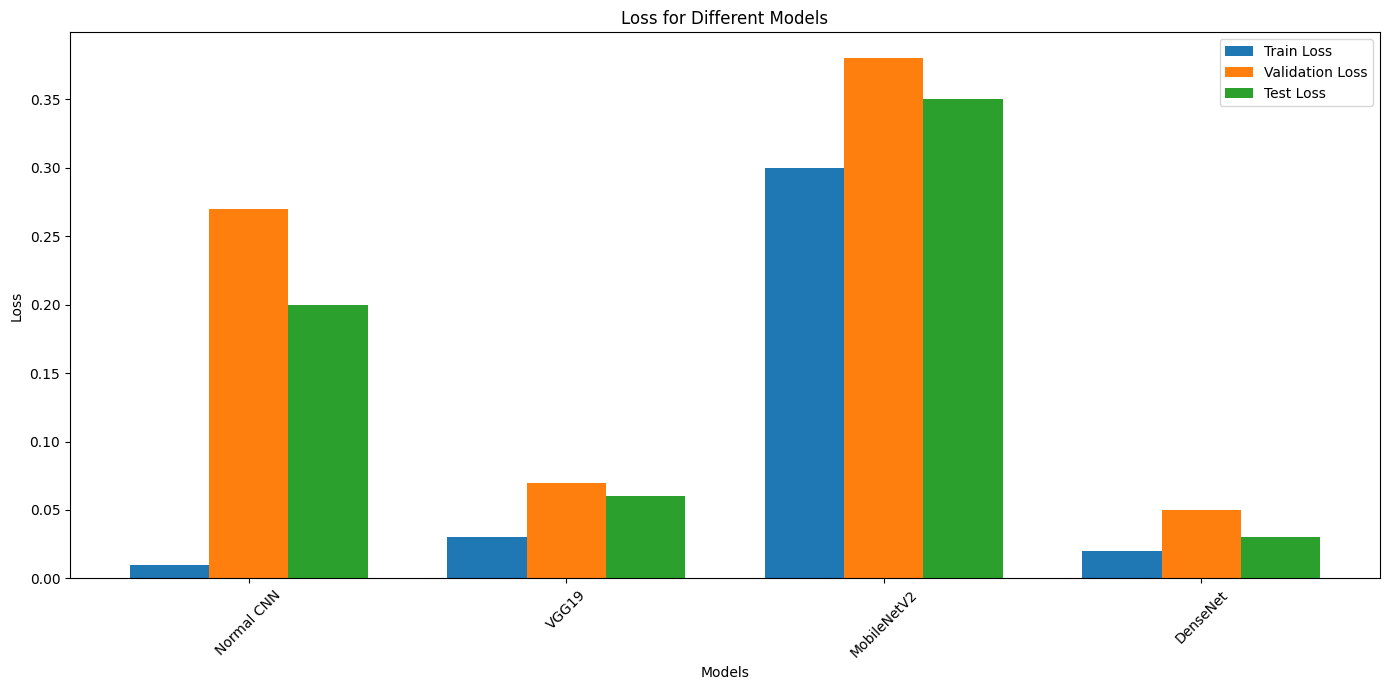

In [45]:
plt.figure(figsize=(14, 7))
bar_width = 0.25  # Width of the bars
index = np.arange(len(Model_Accuracy.index))  # Indices for x-axis

plt.bar(index, Model_Accuracy['Train Loss'], width=bar_width, label='Train Loss')
plt.bar(index + bar_width, Model_Accuracy['Validation Loss'], width=bar_width, label='Validation Loss')
plt.bar(index + 2 * bar_width, Model_Accuracy['Test Loss'], width=bar_width, label='Test Loss')

plt.title('Loss for Different Models')
plt.xlabel('Models')
plt.ylabel('Loss')
plt.xticks(index + bar_width, Model_Accuracy.index, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

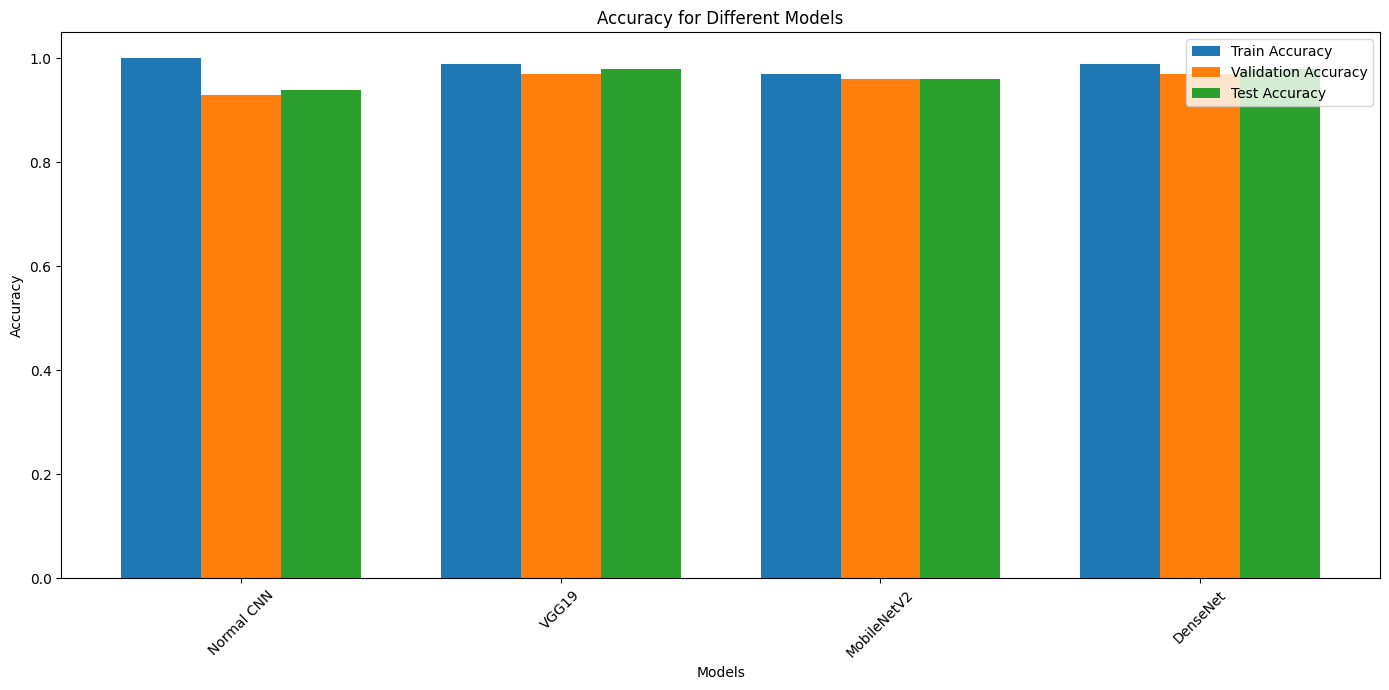

In [46]:
plt.figure(figsize=(14, 7))
plt.bar(index, Model_Accuracy['Train Accuracy'], width=bar_width, label='Train Accuracy')
plt.bar(index + bar_width, Model_Accuracy['Validation ACC'], width=bar_width, label='Validation Accuracy')
plt.bar(index + 2 * bar_width, Model_Accuracy['Test ACC'], width=bar_width, label='Test Accuracy')

plt.title('Accuracy for Different Models')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.xticks(index + bar_width, Model_Accuracy.index, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

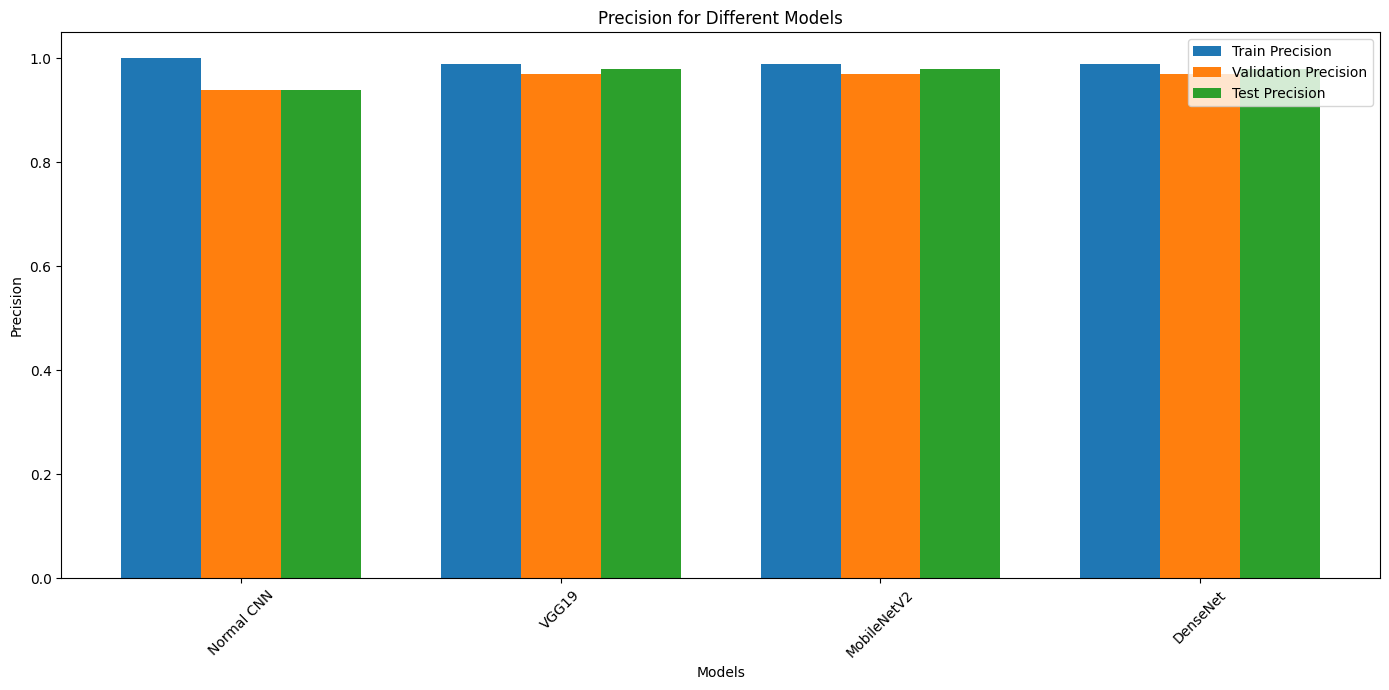

In [47]:
plt.figure(figsize=(14, 7))
plt.bar(index, Model_Accuracy['Train Precision'], width=bar_width, label='Train Precision')
plt.bar(index + bar_width, Model_Accuracy['Validation Precision'], width=bar_width, label='Validation Precision')
plt.bar(index + 2 * bar_width, Model_Accuracy['Test Precision'], width=bar_width, label='Test Precision')

plt.title('Precision for Different Models')
plt.xlabel('Models')
plt.ylabel('Precision')
plt.xticks(index + bar_width, Model_Accuracy.index, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

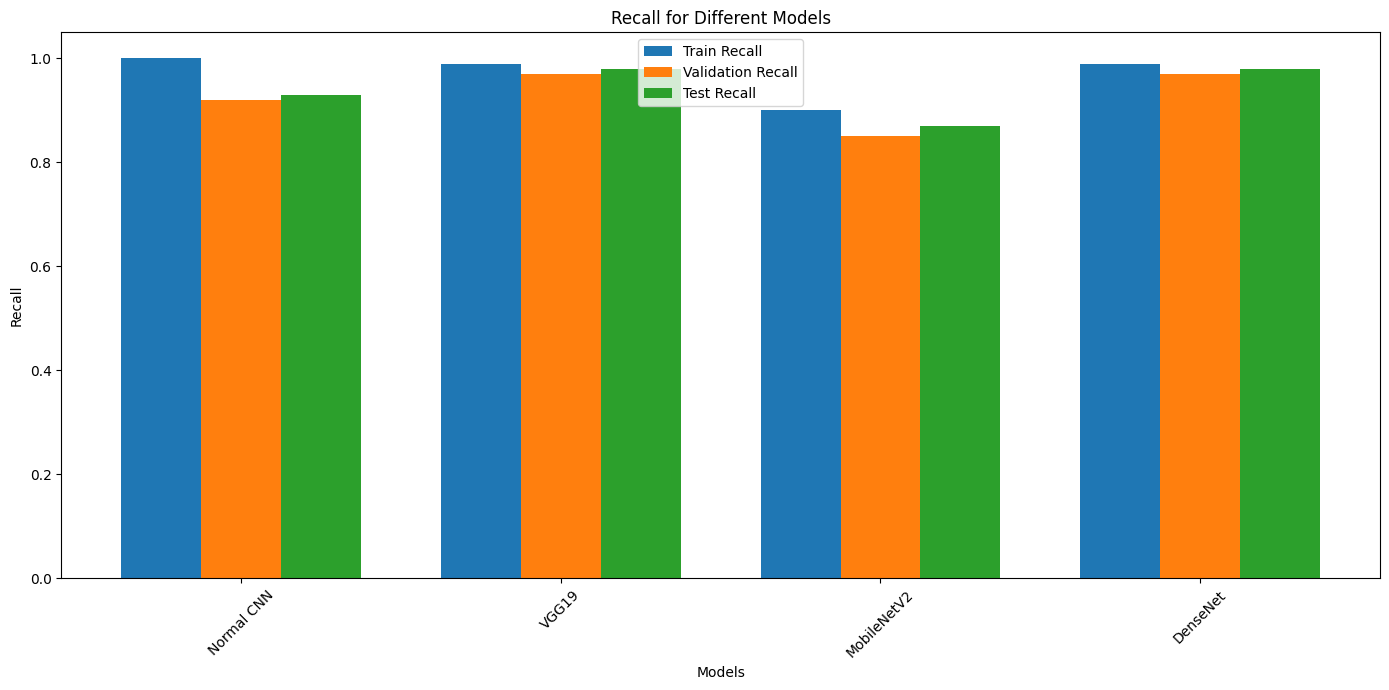

In [48]:
plt.figure(figsize=(14, 7))
plt.bar(index, Model_Accuracy['Train Recall'], width=bar_width, label='Train Recall')
plt.bar(index + bar_width, Model_Accuracy['Validation Recall'], width=bar_width, label='Validation Recall')
plt.bar(index + 2 * bar_width, Model_Accuracy['Test Recall'], width=bar_width, label='Test Recall')

plt.title('Recall for Different Models')
plt.xlabel('Models')
plt.ylabel('Recall')
plt.xticks(index + bar_width, Model_Accuracy.index, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

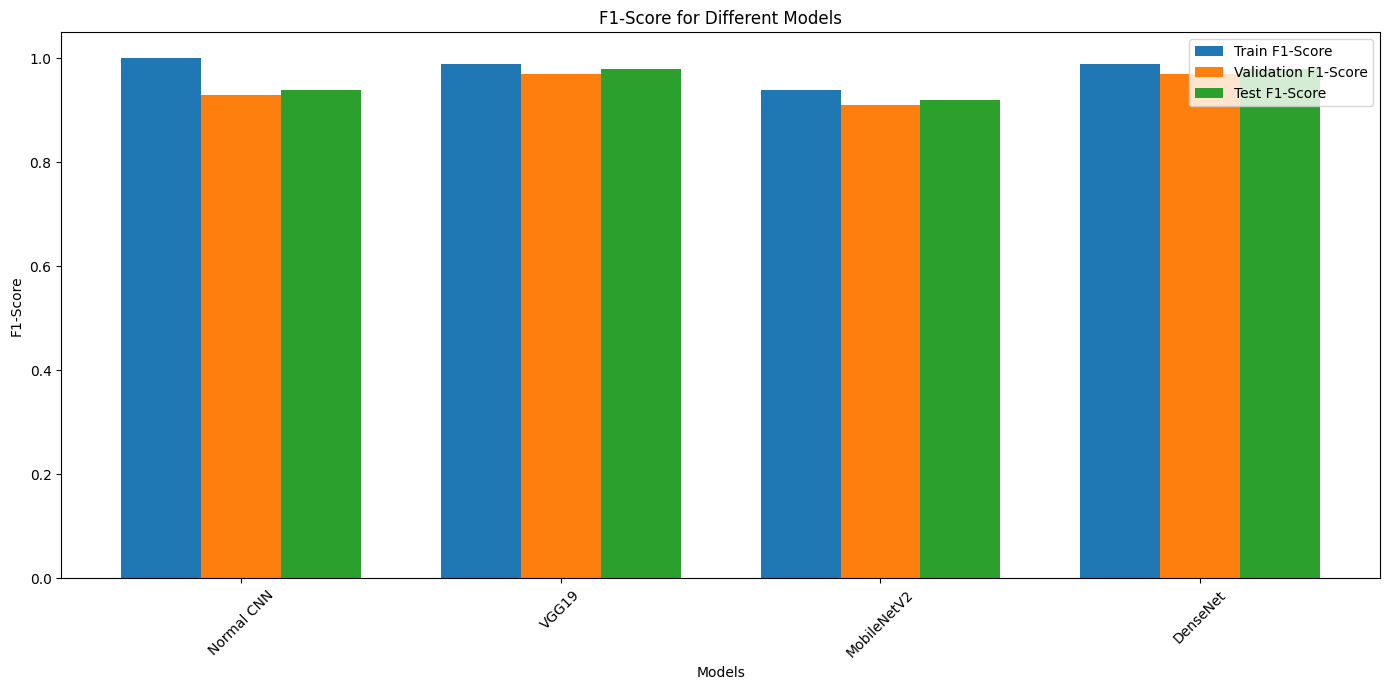

In [49]:
plt.figure(figsize=(14, 7))
plt.bar(index, Model_Accuracy['Train F1-Score'], width=bar_width, label='Train F1-Score')
plt.bar(index + bar_width, Model_Accuracy['Validation F1-Score'], width=bar_width, label='Validation F1-Score')
plt.bar(index + 2 * bar_width, Model_Accuracy['Test F1-Score'], width=bar_width, label='Test F1-Score')

plt.title('F1-Score for Different Models')
plt.xlabel('Models')
plt.ylabel('F1-Score')
plt.xticks(index + bar_width, Model_Accuracy.index, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [50]:
Model_Accuracy.to_csv('Report.csv', index = True)